In [1]:
import os
import pandas as pd
import numpy as np
from pyecg import ECGRecord
import biosignalsnotebooks as bsnb
from numpy import linspace, diff, zeros_like, arange, array
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from scipy import signal
from scipy.signal import correlate
import neurokit2 as nk
import seaborn as sns
import scipy.fft
import pyhrv
import pyhrv.frequency_domain as fd


# We store the data so it can be plotted.
ecg_data = pd.read_csv ('/Users/jmargalef/Molecool/database/new_ecg_data/unclean.csv')
control_data = ecg_data['Control'].tolist()
diabetic_1 = ecg_data['Diabetic_1'].tolist()
diabetic_2 = ecg_data['Diabetic_2'].tolist()
sr = 1000
time = bsnb.generate_time(control_data)

plt.plot(control_data)
plt.plot(diabetic_1)
plt.plot(diabetic_2)
plt.axis([0, 5000, -1000, 2000])


In [31]:
#Step 1 of Pan-Tompkins Algorithm
filtered_signal = bsnb.detect._ecg_band_pass_filter(control_data, sr)
#Step 2 of Pan-Tompkins Algorithm
differentiated_signal = diff(filtered_signal)
#Step 3 of Pan-Tompkins Algorithm
squared_signal = differentiated_signal * differentiated_signal
#Step 4 Moving Window Integration
nbr_sampls_int_wind = int(0.080 * sr)
integrated_signal = zeros_like(squared_signal)
cumulative_sum = squared_signal.cumsum()
integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - cumulative_sum[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / arange(1, nbr_sampls_int_wind + 1)
#Step 5 Detecting the R-peaks
_, rpeaks_1 = nk.ecg_peaks(integrated_signal, sampling_rate=sr) #- Help with this line, phase shift correction!
_, rpeaks_2 = nk.ecg_peaks(control_data, sampling_rate=sr)
_, rpeaks_3 = nk.ecg_peaks(diabetic_1, sampling_rate=sr)
_, rpeaks_4 = nk.ecg_peaks(diabetic_2, sampling_rate=sr)


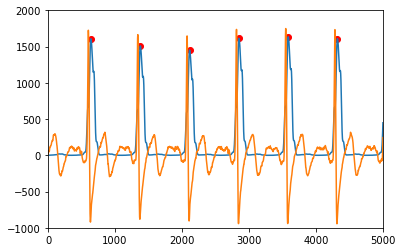

In [71]:
# Correcting the shift between two signals.
time_integrated = bsnb.generate_time(integrated_signal)
time_control = bsnb.generate_time(control_data)

difference = len(time_control)-len(time_integrated)

n=0
while n<difference:
    del control_data[0]
    n+=1
    
_, rpeaks_1 = nk.ecg_peaks(integrated_signal, sampling_rate=sr)
curve, = plt.plot(integrated_signal)
x_data = curve.get_xdata()
y_values = []
for definitive in rpeaks_1['ECG_R_Peaks']:
    value = np.interp(definitive, x_data, integrated_signal)
    y_values.append(value)
    
plt.scatter(rpeaks_1['ECG_R_Peaks'],y_values, c='red')
plt.axis([0, 5000, -1000, 2000])
plt.plot(control_data)
plt.show()

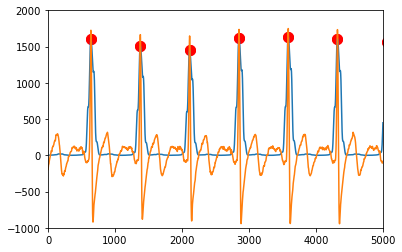

In [32]:
curve, = plt.plot(integrated_signal)
x_data = curve.get_xdata()
y_values = []
for definitive in rpeaks_1['ECG_R_Peaks']:
    value = np.interp(definitive, x_data, integrated_signal)
    y_values.append(value)

plt.axis([0, 5000, -1000, 2000])
plt.scatter(rpeaks_1['ECG_R_Peaks'],y_values, s=100, c='red')
plt.plot(control_data)
plt.scatter(rpeaks_1['ECG_R_Peaks'],y_values, s=100, c='red')

(0.0, 5000.0, -1000.0, 2000.0)

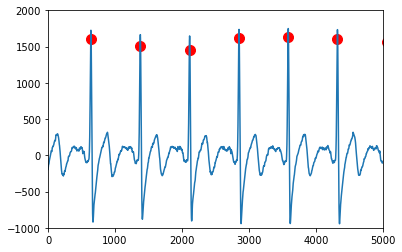

In [33]:
plt.plot(control_data)
plt.scatter(rpeaks_1['ECG_R_Peaks'],y_values, s=100, c='red')
plt.axis([0, 5000, -1000, 2000])

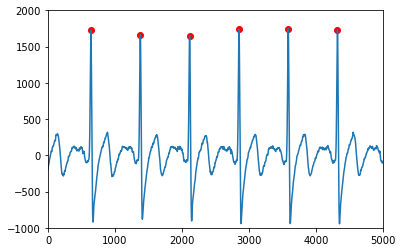

In [13]:
curve2, = plt.plot(control_data)
x_data = curve2.get_xdata()
y_values = []
for definitive in rpeaks_2['ECG_R_Peaks']:
    value = np.interp(definitive, x_data, control_data)
    y_values.append(value)

plt.axis([0, 5000, -1000, 2000])
plt.scatter(rpeaks_2['ECG_R_Peaks'],y_values, c='red')

Text(0, 0.5, 'RR-Interval')

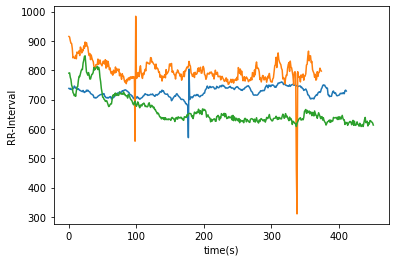

In [14]:
# We calculate the difference between two consecutive R-peaks, we do that for the whole of the signal.
peaks = pd.DataFrame(rpeaks_2)
rpeaks_hrv = peaks['ECG_R_Peaks'].tolist()
rpeaks_hrv.append('NaN')
hrv_values = []
for index, value in enumerate(rpeaks_hrv):
    if rpeaks_hrv[index+1] == 'NaN':
        break
    hrv_values.append(rpeaks_hrv[index+1]-rpeaks_hrv[index])

control_signal, = plt.plot(hrv_values)

peaks_d1 = pd.DataFrame(rpeaks_3)
rpeaks_hrv_d1 = peaks_d1['ECG_R_Peaks'].tolist()
rpeaks_hrv_d1.append('NaN')
hrv_values_d1 = []
for index, value in enumerate(rpeaks_hrv_d1):
    if rpeaks_hrv_d1[index+1] == 'NaN':
        break
    hrv_values_d1.append(rpeaks_hrv_d1[index+1]-rpeaks_hrv_d1[index])
    
diabetis1, = plt.plot(hrv_values_d1)

peaks_d2 = pd.DataFrame(rpeaks_4)
rpeaks_hrv_d2 = peaks_d2['ECG_R_Peaks'].tolist()
rpeaks_hrv_d2.append('NaN')
hrv_values_d2 = []
for index, value in enumerate(rpeaks_hrv_d2):
    if rpeaks_hrv_d2[index+1] == 'NaN':
        break
    hrv_values_d2.append(rpeaks_hrv_d2[index+1]-rpeaks_hrv_d2[index])
    
diabetis2, = plt.plot(hrv_values_d2)
plt.xlabel('time(s)')
plt.ylabel('RR-Interval')



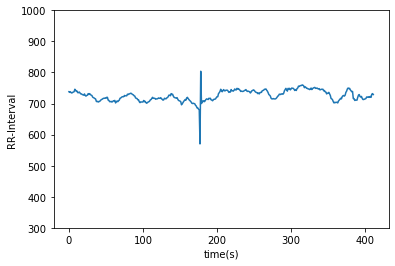

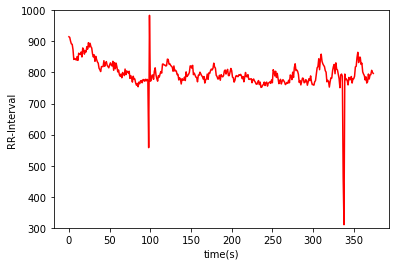

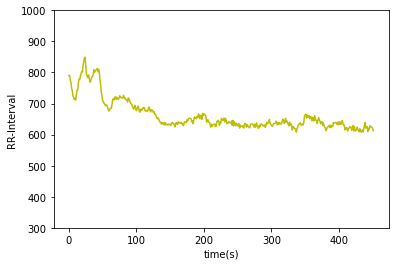

In [15]:
# Plotting HRV signals.

control_signal, = plt.plot(hrv_values)
x_data_hrv_c = control_signal.get_xdata()
plt.xlabel('time(s)')
plt.ylabel('RR-Interval')
ax = plt.gca()
ax.set_ylim([300, 1000])
plt.show()

diabetis1, = plt.plot(hrv_values_d1,'-r')
plt.xlabel('time(s)')
plt.ylabel('RR-Interval')
ax = plt.gca()
ax.set_ylim([300, 1000])
plt.show()

diabetis2, = plt.plot(hrv_values_d2,'-y')
plt.xlabel('time(s)')
plt.ylabel('RR-Interval')
ax = plt.gca()
ax.set_ylim([300, 1000])
plt.show()

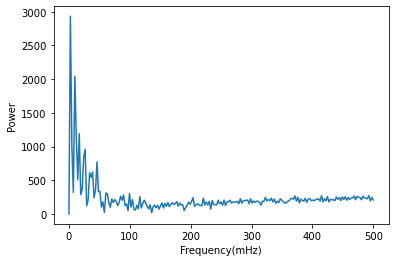

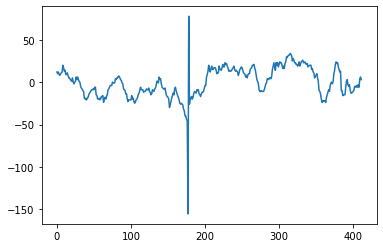

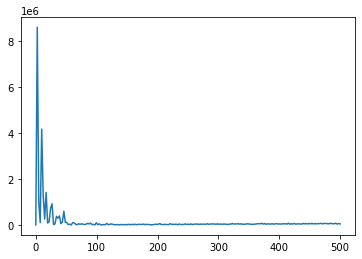

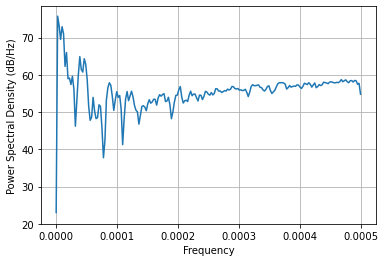

In [39]:
# Computing a FFT - fft function
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft

time = bsnb.generate_time(hrv_values)
time_len = len(time)

# Number of samples in normalized_tone
N = sr * time[time_len-1]
N = int(N)

hrv_values_m = np.mean(hrv_values) # We calculate the mean and we subtract it from every value to normalise the signal.
hrv_fft = hrv_values - hrv_values_m

xf = rfftfreq(N, 1 / sr)
yf = rfft(hrv_fft)
yff = np.square(yf)
new_signal = irfft(yf)

plt.plot(xf,np.abs(yf))
plt.xlabel('Frequency(mHz)')
plt.ylabel('Power')
plt.show()

plt.plot(new_signal)
plt.show()

plt.plot(xf,np.abs(yff))
plt.show()

plt.psd(hrv_fft, 412, 1 / 1000)
plt.show()


In [12]:
time = bsnb.generate_time(hrv_values_d1)
time_len = len(time)

# Number of samples in normalized_tone
N = sr * time[time_len-1]
N = int(N)

hrv_values_m = np.mean(hrv_values_d1) # We calculate the mean and we subtract it from every value to normalise the signal.
hrv_fft = hrv_values - hrv_values_m

xf2 = fftfreq(N, 1 / sr)
yf2 = fft(hrv_fft)

plt.plot(xf2, np.abs(yf2[: 375]),'-r')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Power')
plt.axis([0, 500, 0, 30000])
plt.show()

plt.psd(hrv_fft, 512, 1 / 1000)
plt.show()

time = bsnb.generate_time(hrv_values_d2)
time_len = len(time)
# Number of samples in normalized_tone
N = sr * time[time_len-1]
N = int(N)

hrv_values_m = np.mean(hrv_values_d2) # We calculate the mean and we subtract it from every value to normalise the signal.
hrv_fft = hrv_values - hrv_values_m

xf3 = fftfreq(N, 1 / sr)
yf3 = fft(hrv_fft)

plt.plot(xf3[: 412], np.abs(yf3),'-y')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Power')
plt.axis([0, 500, 0, 25000])
plt.show()

plt.psd(hrv_fft, 512, 1 / 1000)
plt.show()


NameError: name 'hrv_values_d1' is not defined

In [33]:
# Computing FFT - Function plot_psd() hrvanalysis library.
from hrvanalysis import (get_time_domain_features,
                         get_frequency_domain_features)
import hrvanalysis

features_control = get_frequency_domain_features(hrv_values)
print(features_control)
plot_psd(hrv_values)
plt.show()

features_d1 = get_frequency_domain_features(hrv_values_d1)
print(features_d1)
plot_psd(hrv_values_d1)
plt.show()

features_d2 = get_frequency_domain_features(hrv_values_d2)
print(features_d2)
plot_psd(hrv_values_d2)
plt.show()



{'lf': 38.07017899904586, 'hf': 21.15764233537299, 'lf_hf_ratio': 1.799358283668364, 'lfnu': 64.27752725208258, 'hfnu': 35.722472747917415, 'total_power': 166.25088064829765, 'vlf': 107.02305931387879}


NameError: name 'plot_psd' is not defined